In [54]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#IPython.OutputArea.auto_scroll_threshold = 9999;
#plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
import os
import cv2
from random import shuffle

In [2]:
train_im_folder = '/home/ubuntu/efs/data/cones/train/images/'
train_label_folder = '/home/ubuntu/efs/data/cones/train/labels/'
train_label_folder_target = './labels_new/train'
val_im_folder = './images/val/'
val_label_folder = './labels/val/'
val_label_folder_target = './labels_new/val'


In [3]:
def normalize(im):
    normalizedImg = np.zeros_like(im)
    cv2.normalize(im,  normalizedImg, 0, 255, cv2.NORM_MINMAX)
    return normalizedImg

In [4]:
# offset in procent
def crop_by_id(ft_raw, idx, offset_l = 0.0, offset_r = 0.0, offset_u = 0.0, offset_d = 0.0):
    min_x = int(ft_raw[idx][1])
    min_y = int(ft_raw[idx][2])
    max_x = int(ft_raw[idx][3])
    max_y = int(ft_raw[idx][4])
    os_pixel_l = int(round((max_x - min_x) * offset_l))
    os_pixel_r = int(round((max_x - min_x) * offset_r))
    
    os_pixel_u = int(round((max_y - min_y) * offset_u))
    os_pixel_d = int(round((max_y - min_y) * offset_d))
    min_x += os_pixel_l
    min_y += os_pixel_u
    max_x -= os_pixel_r
    max_y -= os_pixel_d
    return im[ min_y:max_y, min_x:max_x,:]

In [5]:
def crop(im, offset_l = 0.0, offset_r = 0.0, offset_u = 0.0, offset_d = 0.0):
    min_x = 0
    min_y = 0
    max_x = im.shape[1]
    max_y = im.shape[0]
    os_pixel_l = int(round((max_x - min_x) * offset_l))
    os_pixel_r = int(round((max_x - min_x) * offset_r))
    
    os_pixel_u = int(round((max_y - min_y) * offset_u))
    os_pixel_d = int(round((max_y - min_y) * offset_d))
    min_x += os_pixel_l
    min_y += os_pixel_u
    max_x -= os_pixel_r
    max_y -= os_pixel_d
    return im[ min_y:max_y, min_x:max_x,:]

In [6]:
def plot_his(or_img):
    color = ('b','g','r')
    for i,col in enumerate(color):
        histr = cv2.calcHist([or_img],[i],None,[256],[0,256])
        plt.plot(histr,color = col)
        plt.xlim([0,260])
    #plt.show()
    
def plot_hsv(or_img):
    hsv = cv2.cvtColor(or_img,cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist( [hsv], [0, 1], None, [180, 256], [0, 180, 0, 256] )
    plt.imshow(hist,interpolation = 'nearest')
    plt.show()
    
def plot_gray(or_img):
    histr_gray = cv2.calcHist([cv2.cvtColor(or_img, cv2.COLOR_BGR2GRAY)],[0],None,[256],[0,256])
    plt.plot(histr_gray,color = 'r')
    plt.xlim([0,260])

In [7]:
def blue_rate(im):
    s_b = im[:,:,0].sum()
    s_g = im[:,:,1].sum()
    s_r = im[:,:,2].sum()
    return s_b / (s_b + s_g + s_r)

def red_rate(im):
    s_b = im[:,:,0].sum()
    s_g = im[:,:,1].sum()
    s_r = im[:,:,2].sum()
    return s_r / (s_b + s_g + s_r)

In [89]:
def is_blue(im):
    blue_rate_thres = 0.35
    if blue_rate(crop(im, offset_l = 0.2, offset_r = 0.2, offset_u = 0.6, offset_d = 0.05)) > blue_rate_thres:
        #print 'blue rate: ', blue_rate(crop(im, offset_l = 0.2, offset_r = 0.2, offset_u = 0.6, offset_d = 0.05)) 
        return True
    else:
        return False
def is_yellow(im):
    intent1 = np.average(crop(im, offset_l = 0.3, offset_r = 0.3, offset_u = 0.1, offset_d = 0.68))
    intent2 = np.average(crop(im, offset_l = 0.3, offset_r = 0.3, offset_u = 0.28, offset_d = 0.43))
    intent3 = np.average(crop(im, offset_l = 0.3, offset_r = 0.3, offset_u = 0.53, offset_d = 0.1))
    if intent1 - intent2 > 3 and intent3 - intent2 > 3:
        return True
    else:
        return False
def is_big_orange(im):
    intent1 = np.average(crop(im, offset_l = 0.35, offset_r = 0.35, offset_u = 0.05, offset_d = 0.72))
    intent2 = np.average(crop(im, offset_l = 0.35, offset_r = 0.35, offset_u = 0.22, offset_d = 0.57))
    intent3 = np.average(crop(im, offset_l = 0.35, offset_r = 0.35, offset_u = 0.37, offset_d = 0.42))
    intent4 = np.average(crop(im, offset_l = 0.35, offset_r = 0.35, offset_u = 0.52, offset_d = 0.22))
    intent5 = np.average(crop(im, offset_l = 0.35, offset_r = 0.35, offset_u = 0.77, offset_d = 0.05))
    if intent1 - intent2 < 3 and intent2 - intent3 > 3 and intent3 - intent4 < 3 and intent4 - intent5 > 3:
        return True
    else:
        return False

In [91]:
def predict(im):
    im = normalize(im)
    classes = ['blue', 'yellow', 'orange', 'big_orange']
    if is_blue(im):
        return classes[0]
    if is_big_orange(im):
        return classes[3]
    if is_yellow(im):
        return classes[1]
    return classes[2]

In [81]:
def predict_olde(im):
    #im = normalize(im)
    blue_rate_thres = 0.35
    classes = ['blue', 'yellow', 'orange', 'big_orange']
    ave_im = np.average(im)
    #print 'ave_im: ', ave_im
    #print 'ave_for_yellow: ', np.average(crop(im, offset_l = 0.4, offset_r = 0.4, offset_u = 0.35, offset_d = 0.45))
    
    #ave_intensity_black_thres = 125
    ave_intensity_black_thres = ave_im
    ave_intensity_write_thres = 200
    red_rate_thres = 0.45
    
    #np.average(crop(im, offset_l = 0.35, offset_r = 0.35, offset_u = 0.3, offset_d = 0.4))
    #for blue
    if blue_rate(crop(im, offset_l = 0.2, offset_r = 0.2, offset_u = 0.6, offset_d = 0.05)) > blue_rate_thres:
        return classes[0]
    elif np.average(crop(im, offset_l = 0.4, offset_r = 0.4, offset_u = 0.4, offset_d = 0.45)) < ave_intensity_black_thres:
        #print 'intensity:', np.average(crop(im, offset_l = 0.4, offset_r = 0.4, offset_u = 0.4, offset_d = 0.45))
        return classes[1]
    elif  red_rate(crop(im, offset_l = 0.3, offset_r = 0.3, offset_u = 0.6, offset_d = 0.3)) > red_rate_thres:
        #print 'intensity:', np.average(crop(im, offset_l = 0.3, offset_r = 0.3, offset_u = 0.6, offset_d = 0.3))
        #print 'red rate: ', red_rate(crop(im, offset_l = 0.3, offset_r = 0.3, offset_u = 0.6, offset_d = 0.3))
        #print 'red rate yellow: ', red_rate(crop(im, offset_l = 0.4, offset_r = 0.4, offset_u = 0.4, offset_d = 0.45))
        return classes[2]
    else:
        #print 'red rate: ', red_rate(crop(im, offset_l = 0.3, offset_r = 0.3, offset_u = 0.6, offset_d = 0.3))
        return classes[3]
        

In [82]:
def plot_all(im_id):
    plt.figure(figsize=(30,10))
    plt.subplot(131)
    plt.imshow(cv2.cvtColor(im_c[im_id], cv2.COLOR_BGR2RGB))
    plt.subplot(132)
    plot_gray(im_c[im_id])
    plt.subplot(133)
    plot_his(im_c[im_id])
    plt.show()

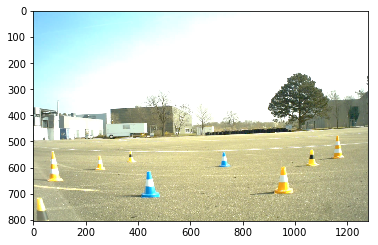

In [83]:
pim = os.path.join(train_im_folder, '1042_26.png')
plabel = os.path.join(train_label_folder, '1042_26.txt')
im = normalize(cv2.imread(pim))
plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))

ave intensity: 179.637605725


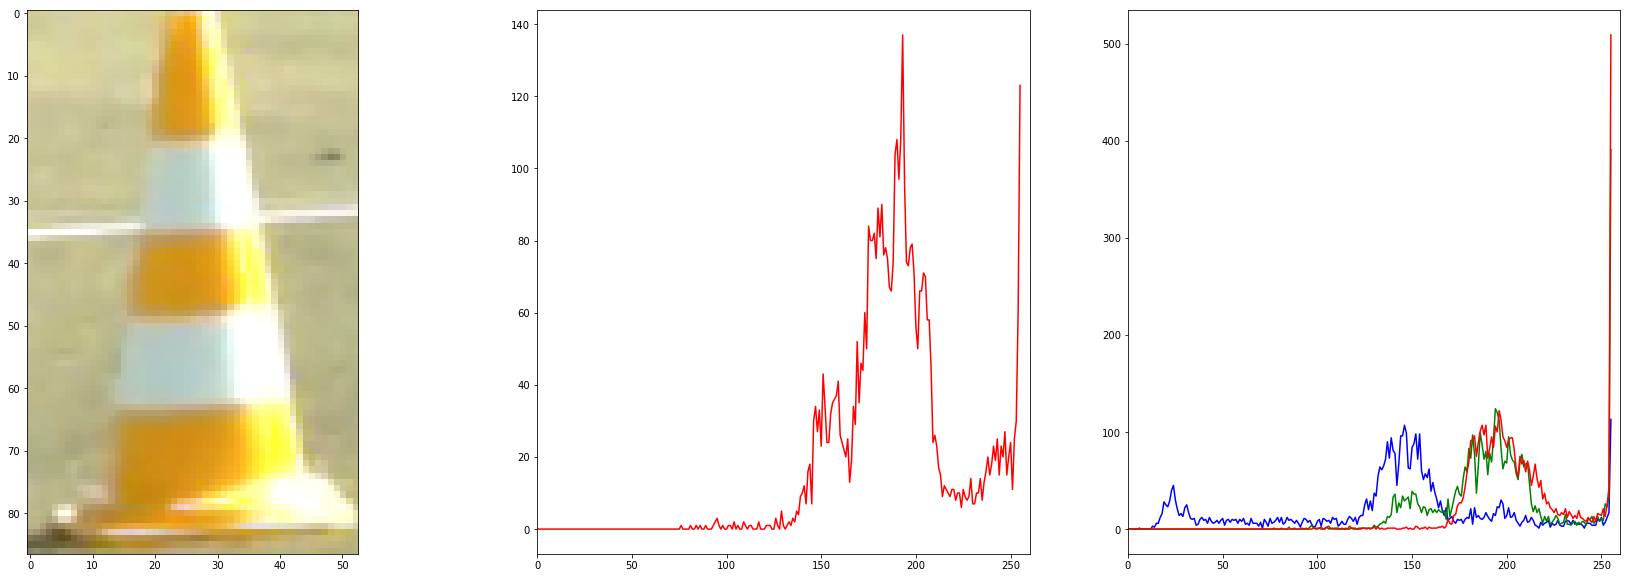

ave intensity: 176.517482517


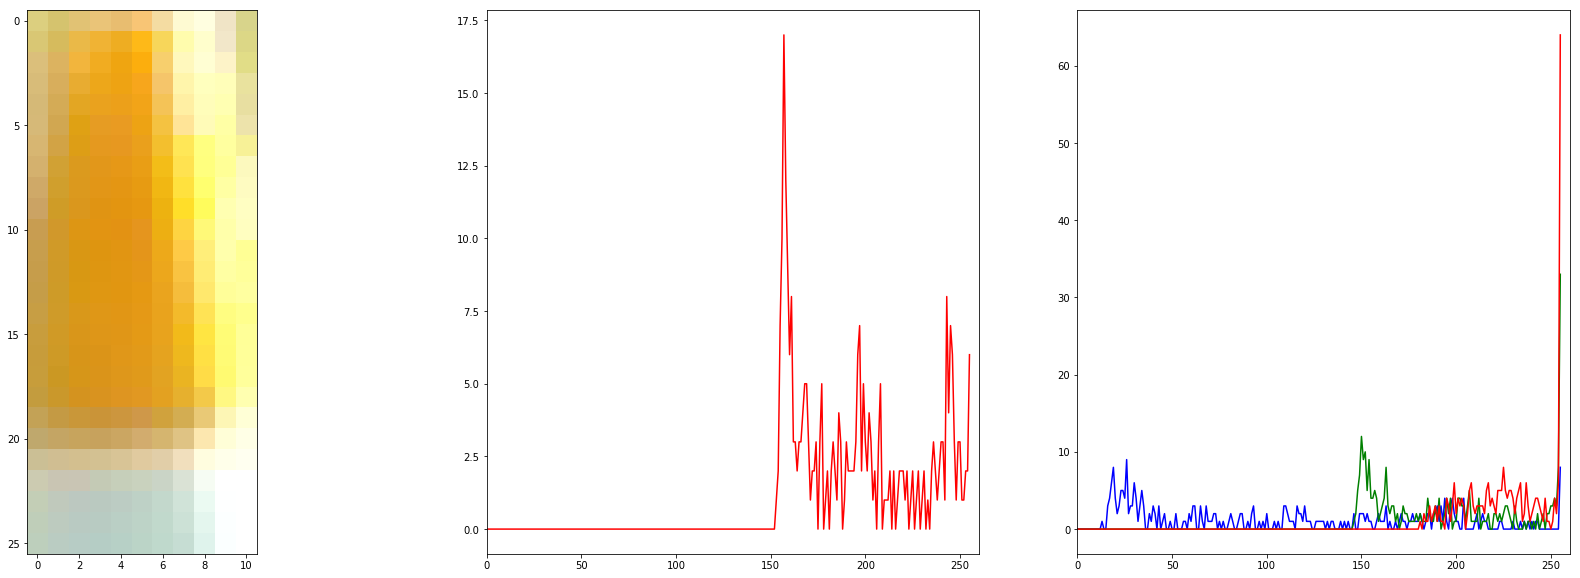

ave intensity: 190.458677686


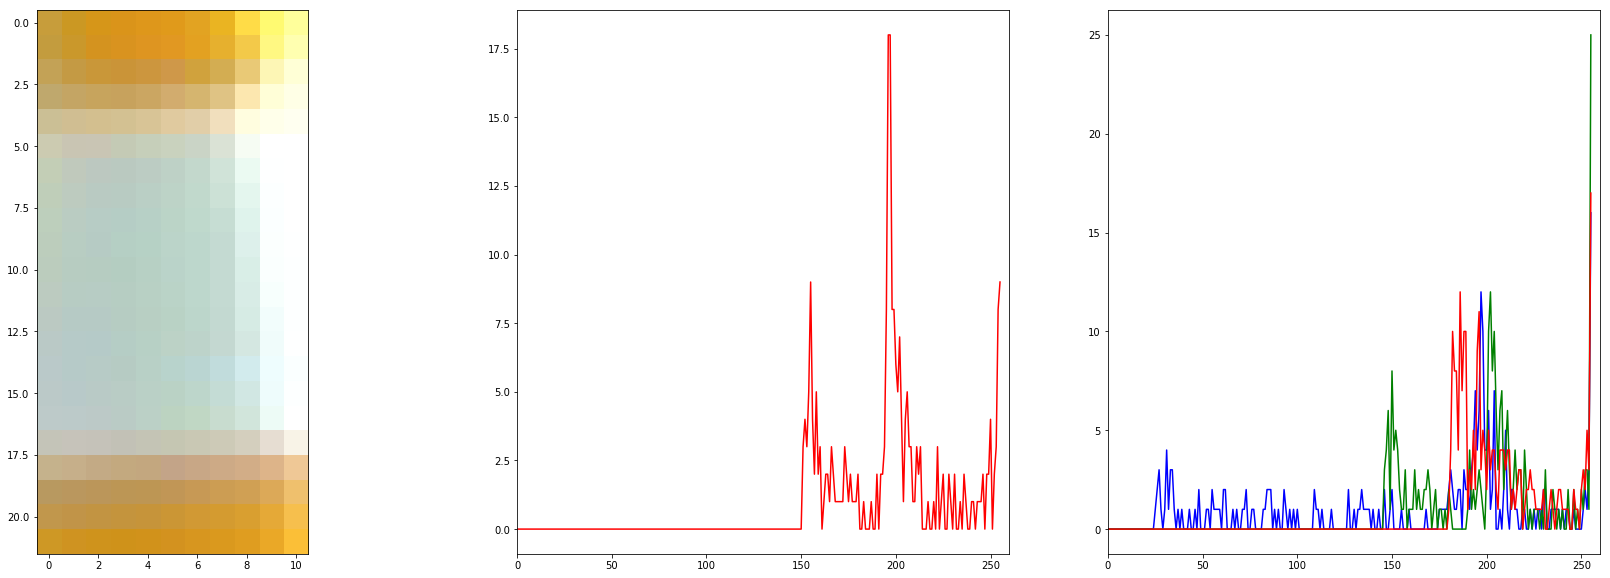

ave intensity: 162.221763085


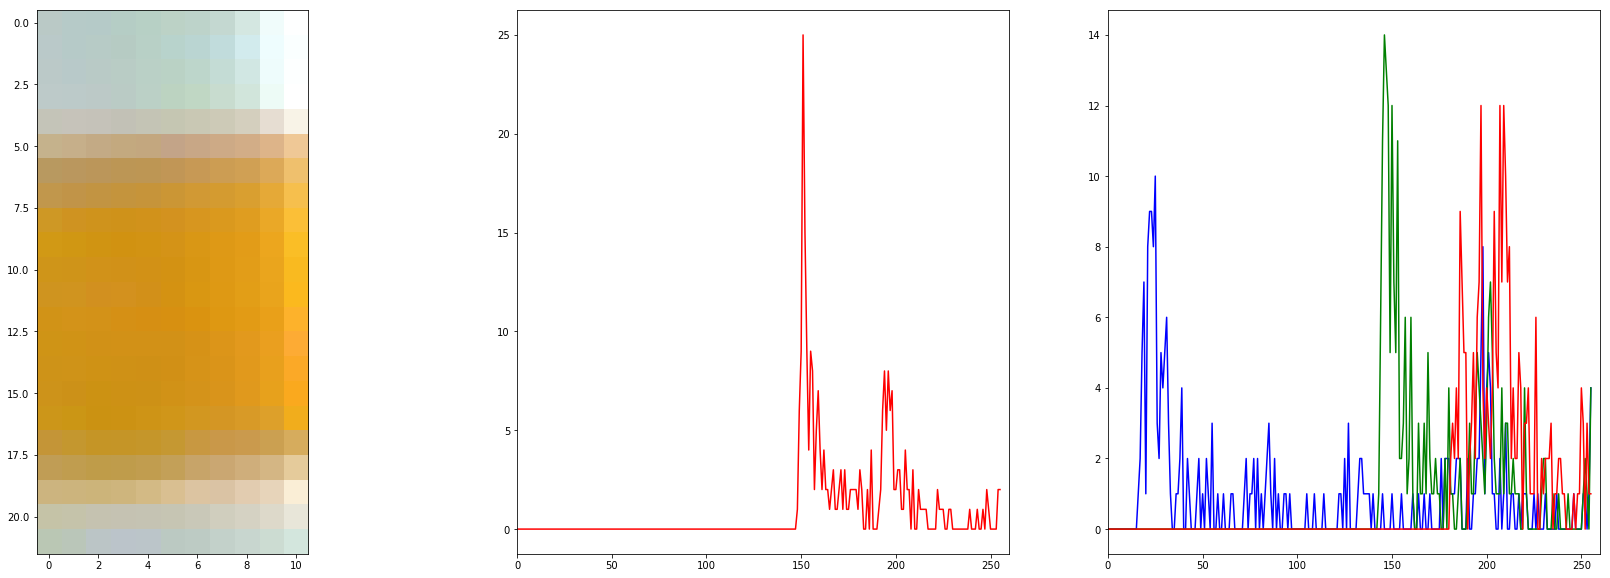

ave intensity: 169.304195804


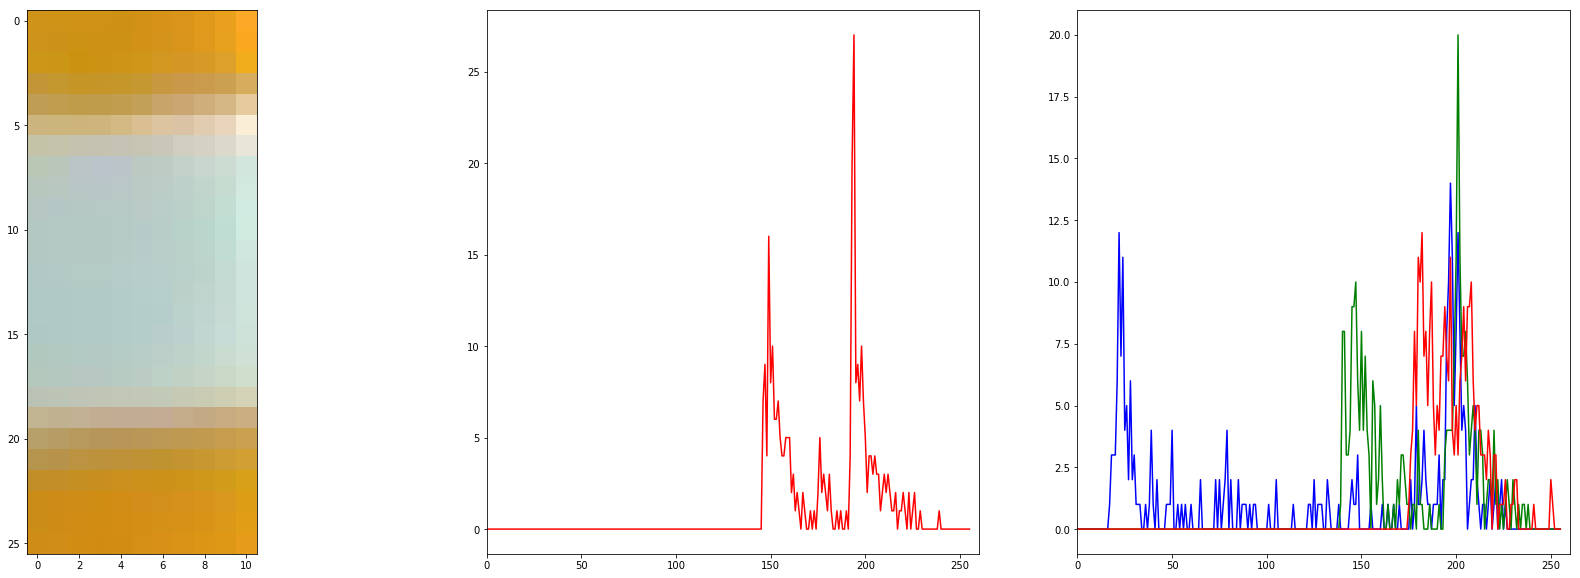

ave intensity: 141.922865014


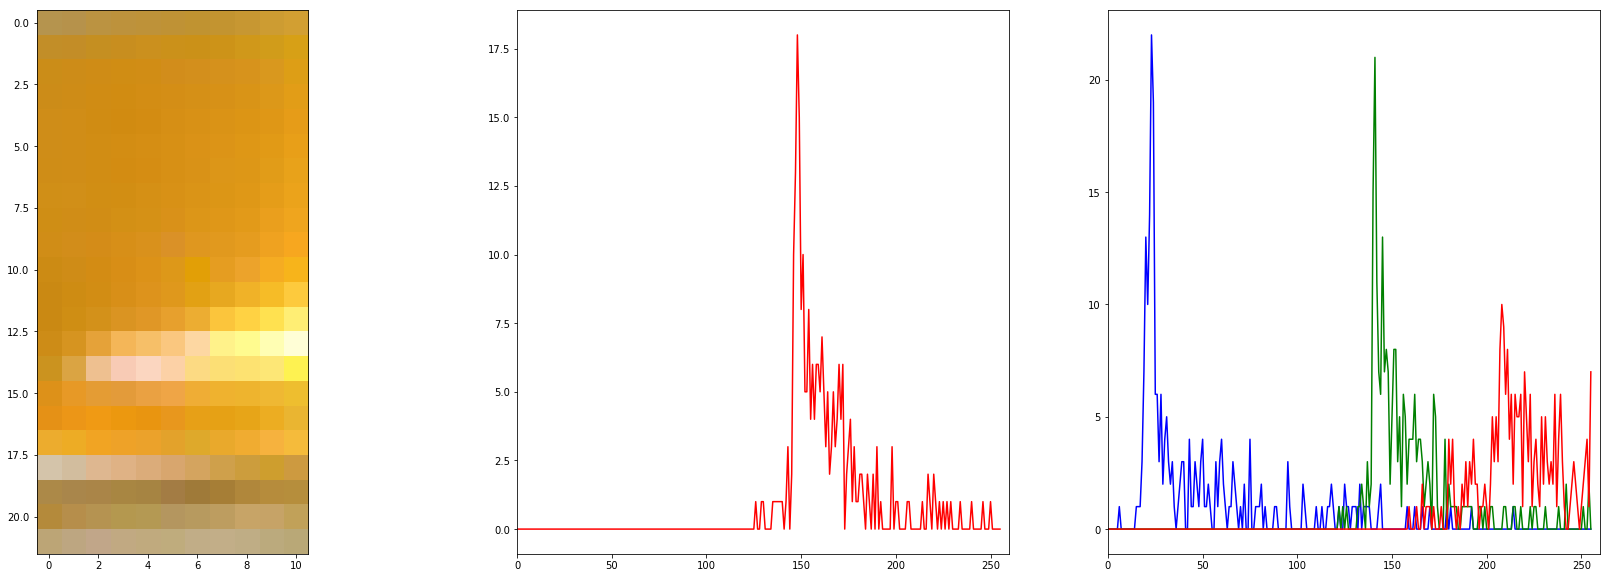

ave intensity: 191.680955512


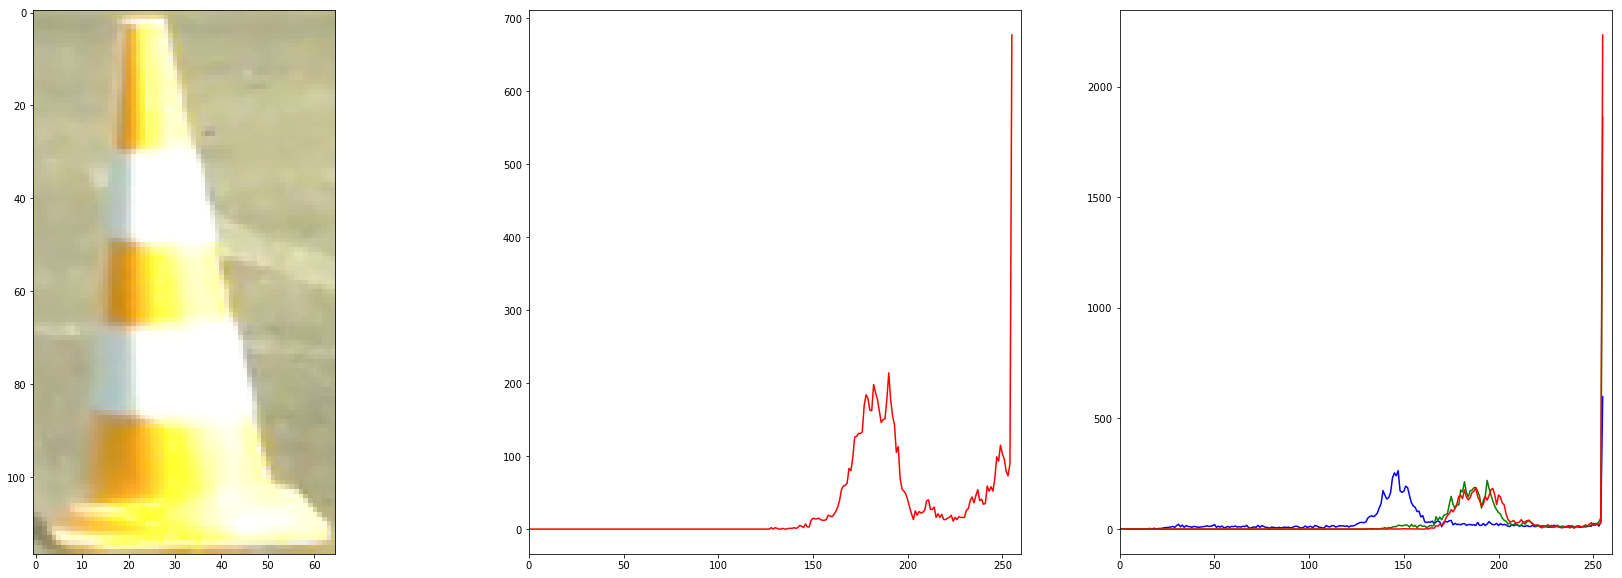

ave intensity: 204.503296703


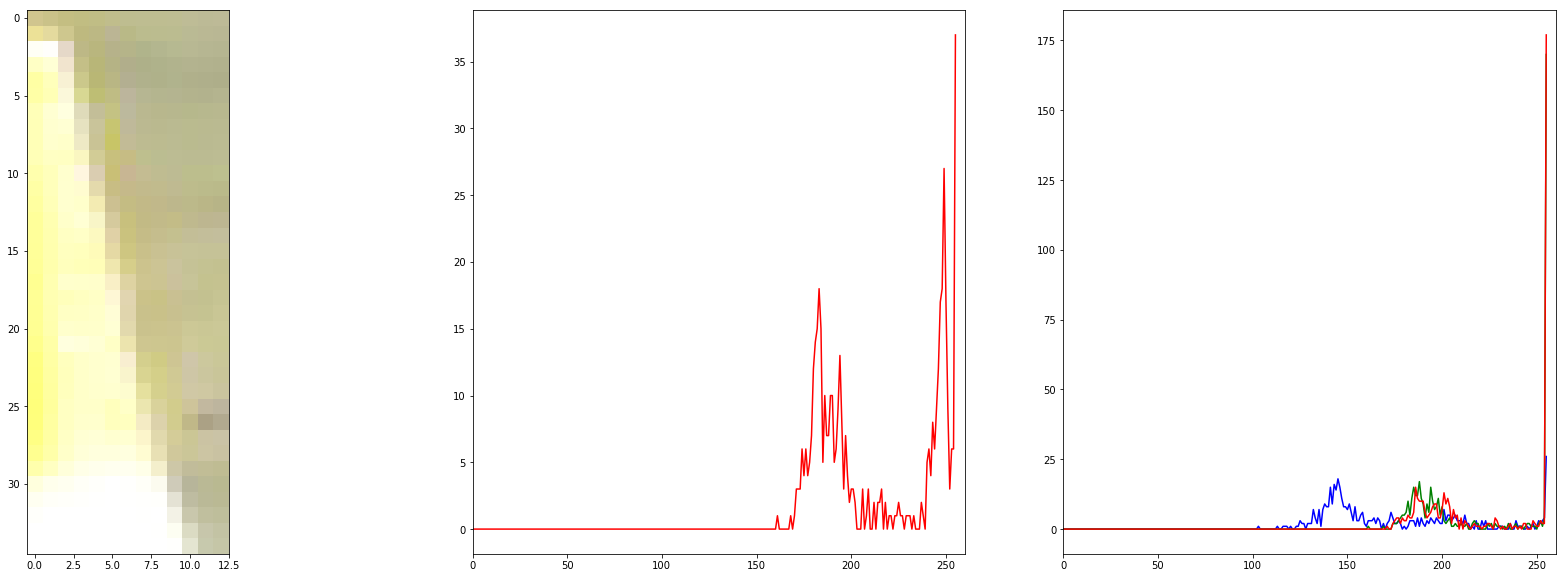

ave intensity: 238.190598291


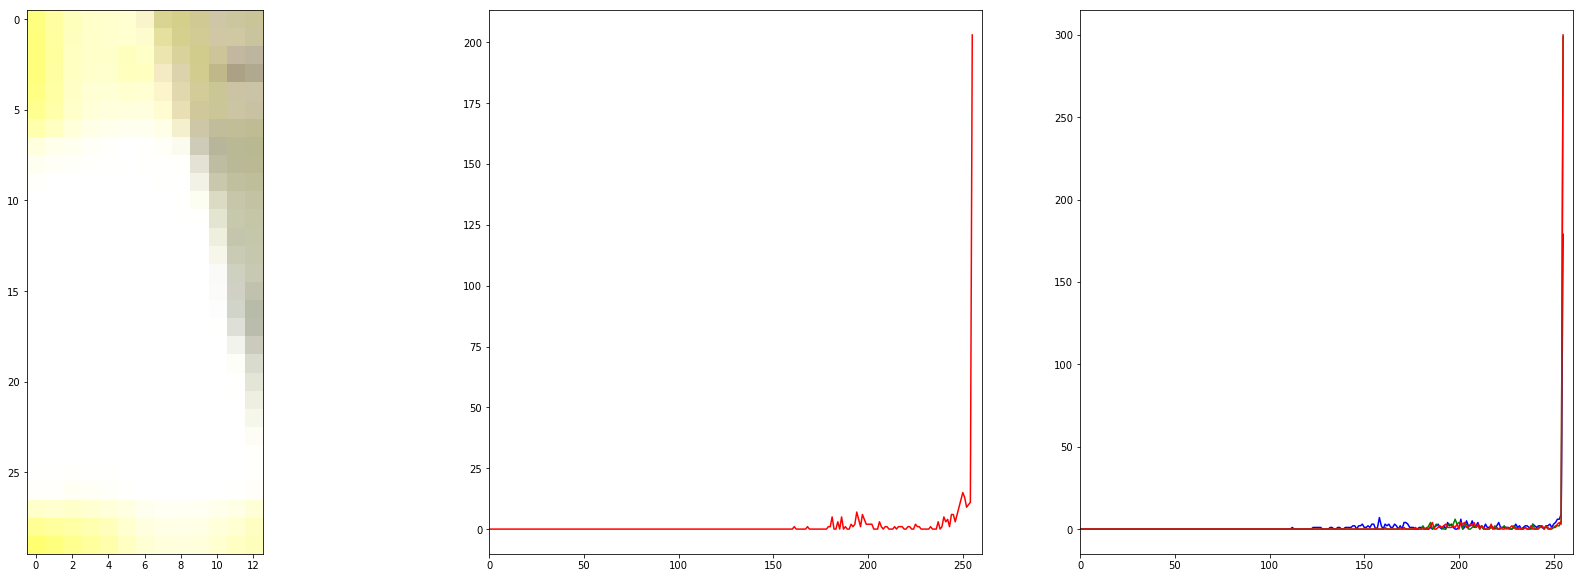

ave intensity: 235.162687887


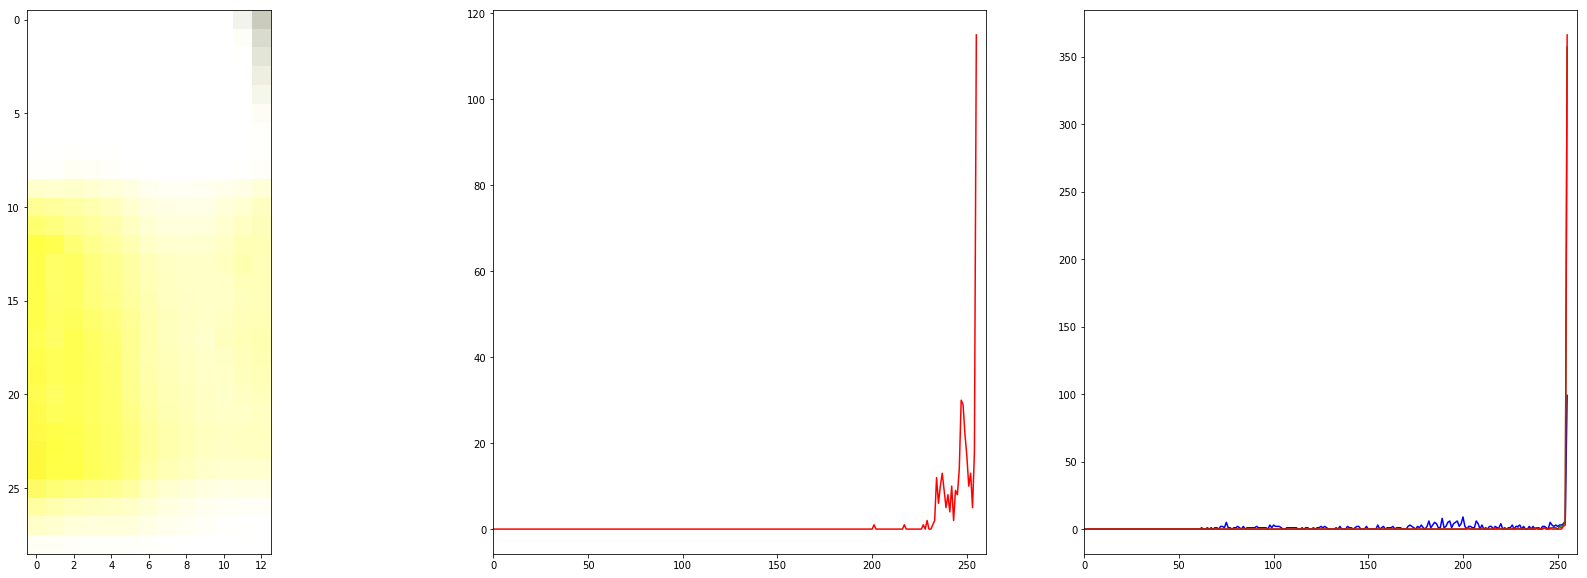

ave intensity: 239.24029304


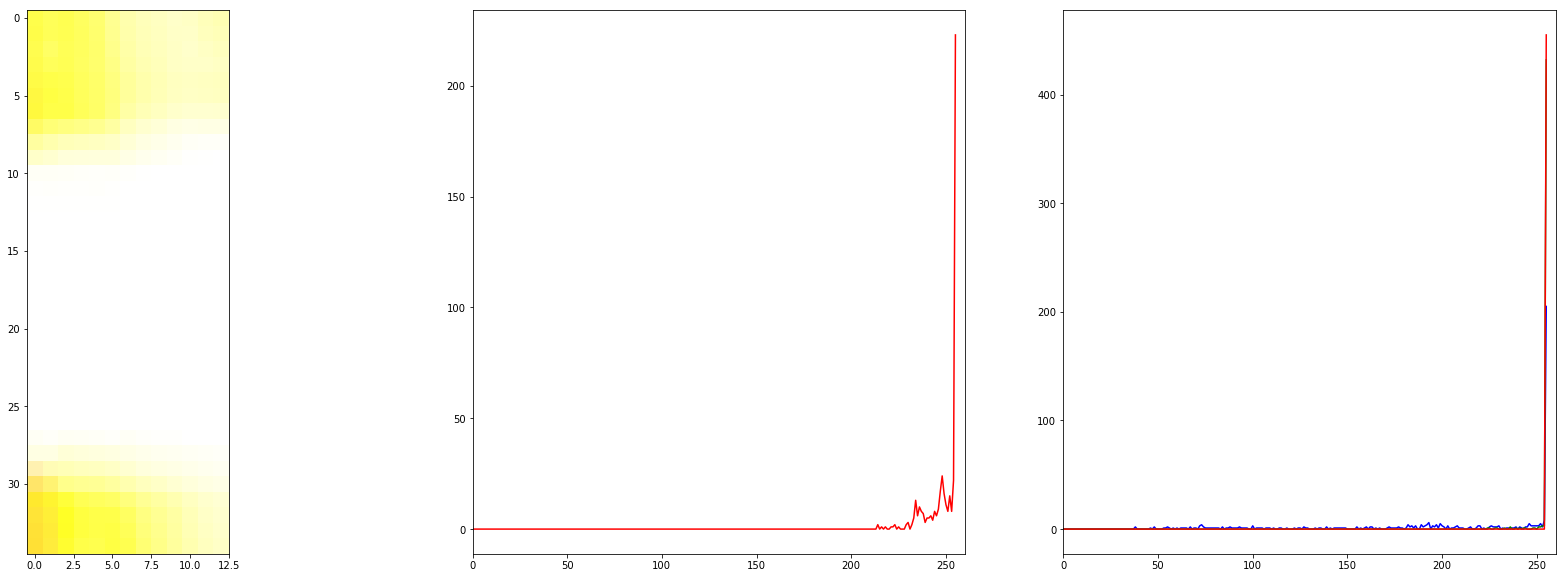

ave intensity: 205.821396994


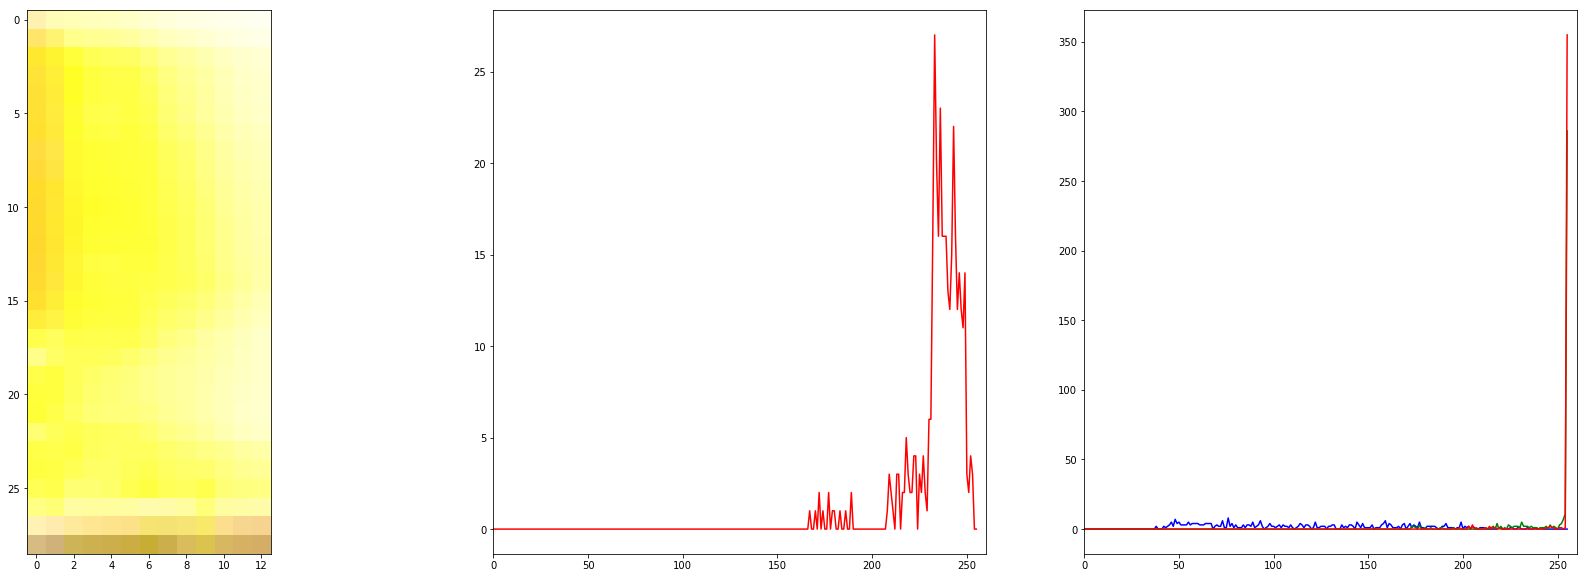

In [48]:
ft_raw = []
with open(plabel) as f_train_label:
    for ft in f_train_label:
        ft_raw.append(ft.split())# 4567
im_c = []
#for i in range(len(ft_raw)):
for i in [0, 5]:

    im_c.append(crop_by_id(ft_raw, i, offset_l = 0.0, offset_r = 0.0, offset_u = 0.0, offset_d = 0.0))# for blue
    #im_c.append(crop_by_id(ft_raw, i, offset_l = 0.2, offset_r = 0.2, offset_u = 0.6, offset_d = 0.05))# for blue(sum blue)
    #im_c.append(crop_by_id(ft_raw, i, offset_l = 0.35, offset_r = 0.35, offset_u = 0.3, offset_d = 0.4))# for yellow(sum all)
    
    im_c.append(crop_by_id(ft_raw, i, offset_l = 0.4, offset_r = 0.4, offset_u = 0, offset_d = 0.70))# for big orange
    im_c.append(crop_by_id(ft_raw, i, offset_l = 0.4, offset_r = 0.4, offset_u = 0.2, offset_d = 0.55))# for big orange
    im_c.append(crop_by_id(ft_raw, i, offset_l = 0.4, offset_r = 0.4, offset_u = 0.35, offset_d = 0.4))# for big orange
    im_c.append(crop_by_id(ft_raw, i, offset_l = 0.4, offset_r = 0.4, offset_u = 0.5, offset_d = 0.2))# for big orange
    im_c.append(crop_by_id(ft_raw, i, offset_l = 0.4, offset_r = 0.4, offset_u = 0.75, offset_d = 0))# for big orange
for j in xrange(len(im_c)):
    #if j % 2 == 0:
    #    print 'predict: ', predict(im_c[j])
        #pass
    #if j % 3 == 1:
    #    print 'blue rate:', blue_rate(im_c[j])
    #if j % 2 == 1:
    print 'ave intensity:', np.average(im_c[j])
    #print 'predict: ', predict(im_c[j])
    plot_all(j)


## Visualization

In [70]:
def plot_predit(image, label):
    inv_classes = {'blue':0, 'yellow':1, 'orange':2, 'big_orange':3}
    #colors = plt.cm.hsv(np.linspace(0, 1, 6)).tolist()
    colors = ['#0000ff','#ffff00', '#ff9900', '#ff0000']
    plt.figure(figsize = (20,20))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    currentAxis = plt.gca()
    for l in label:
        min_x = int(l[1])
        min_y = int(l[2])
        max_x = int(l[3])
        max_y = int(l[4])
        label_name = l[0]
        display_txt = '{}'.format(label_name)
        coords = (min_x, min_y), max_x-min_x+1, max_y-min_y+1
        color = colors[inv_classes[label_name]]
        currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor= color, linewidth=2))
        currentAxis.text(min_x, min_y, display_txt, bbox={'facecolor':color, 'alpha':0.3})

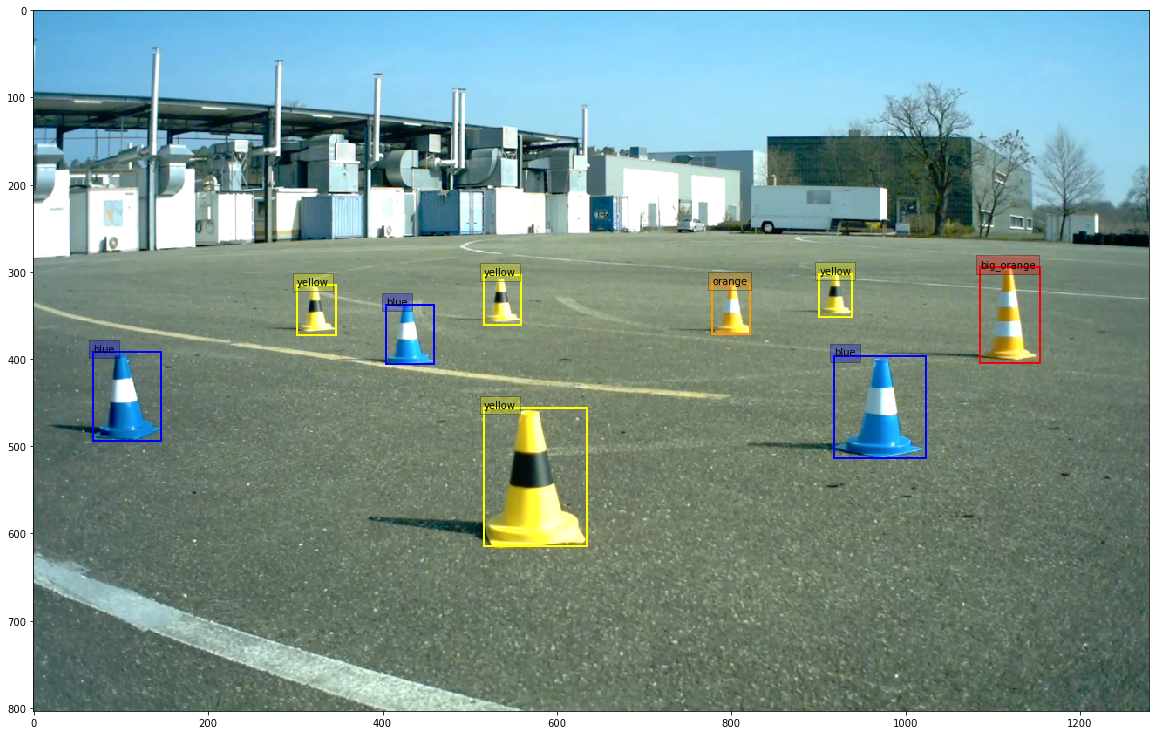

In [95]:
im_folder = train_im_folder
label_folder = train_label_folder

files = []
for (dirpath, dirnames, filenames) in os.walk(im_folder):
    files.extend(filenames)
    break
#shuffle(files)
for im_file in files[82:83]:
    label_file = os.path.splitext(im_file)[0] + '.txt'
    labels = []
    with open(os.path.join(label_folder, label_file)) as f_label:
        for ft in f_label:
            labels.append(ft.split())
    im = cv2.imread(os.path.join(im_folder, im_file))
    for lab in labels:
        lab[0] = predict(im[int(lab[2]):int(lab[4]), int(lab[1]):int(lab[3]), :])
    plot_predit(im, labels)   
    plt.savefig('test.png', bbox_inches='tight', pad_inches=0)

In [122]:
plt.cm.hsv(np.linspace(0, 1, 6)).tolist()

[[1.0, 0.0, 0.0, 1.0],
 [0.8187488187488188, 1.0, 0.0, 1.0],
 [0.0, 1.0, 0.3625004724974957, 1.0],
 [0.0, 0.4562523625023627, 1.0, 1.0],
 [0.724998818748819, 0.0, 1.0, 1.0],
 [1.0, 0.0, 0.09375, 1.0]]

In [106]:
labels

[['yellow', '100', '609', '262', '802'],
 ['blue', '72', '396', '116', '452'],
 ['yellow', '154', '378', '190', '421'],
 ['yellow', '242', '420', '298', '492'],
 ['big_orange', '278', '380', '318', '427'],
 ['big_orange', '345', '368', '380', '409'],
 ['big_orange', '506', '375', '545', '423'],
 ['blue', '577', '368', '612', '407'],
 ['blue', '586', '412', '644', '481'],
 ['yellow', '794', '378', '832', '427']]

('08_42', '.png')

In [ ]:
for i in range(len(ft_raw)):
    im_c.append(crop_by_id(ft_raw, i, offset_l = 0.0, offset_r = 0.0, offset_u = 0.0, offset_d = 0.0))

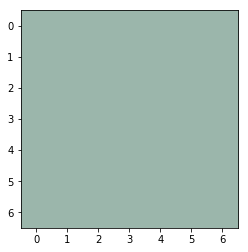

In [63]:
img = im_c[5]
Z = img.reshape((-1,3))

# convert to np.float32
Z = np.float32(Z)

# define criteria, number of clusters(K) and apply kmeans()
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 1
ret,label,center=cv2.kmeans(Z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)

# Now convert back into uint8, and make original image
center = np.uint8(center)
res = center[label.flatten()]
res2 = res.reshape((img.shape))
plt.imshow(cv2.cvtColor(res2, cv2.COLOR_BGR2RGB))

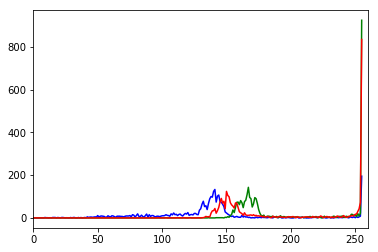

In [71]:
white = 

In [62]:
aaaa = np.array([1, 2, 3,4])